<a href="https://colab.research.google.com/github/rpeloff/MAML/blob/master/maml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: MAML in kind of xxx lines of TF 2.0? (ignoring the model weight update thing)

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
import tensorflow
print(tensorflow.__version__)  

2.0.0-rc2


### This implementation was guided by this fantastic blog post: [Meta-Learning in 50 Lines of JAX](https://blog.evjang.com/2019/02/maml-jax.html)

# Gradients n stuff ✨

The TensorFlow 2.0 Eager (beaver) way of taking gradients: [gradient tapes](https://www.tensorflow.org/tutorials/customization/autodiff#gradient_tapes). Let's create a gradient function to make managing these "tapes" easier:

In [0]:
def gradient(func):
    """Return function that takes gradient of `func` w.r.t. some variables."""
    def grad_func(*args, targets=None, watch_list=None):
        if targets is None:
            targets = args[0]  # differentiate w.r.t first if no targets
        with tf.GradientTape() as tape:
            if watch_list is not None:
                for var in watch_list:
                    tape.watch(watch_list)
            func_value = func(*args)
        grad_value = tape.gradient(func_value, targets)
        return grad_value
    return grad_func

In [0]:
f = lambda x, y: tf.square(x) + y

In [0]:
x_0 = tf.Variable(4.)
y_0 = tf.Variable(5.)

In [0]:
f_prime = gradient(f)

In [8]:
print("f({}, {}) = {}".format(x_0.numpy(), y_0.numpy(), f(x_0, y_0).numpy()))

f(4.0, 5.0) = 21.0


In [9]:
f_prime_x0 = f_prime(x_0, y_0, targets=x_0)
print("df/dx({}, {}) = {}".format(x_0.numpy(), y_0.numpy(), f_prime_x0.numpy()))

df/dx(4.0, 5.0) = 8.0


In [10]:
f_prime_y0 = f_prime(x_0, y_0, targets=y_0)
print("df/dy({}, {}) = {}".format(x_0.numpy(), y_0.numpy(), f_prime_y0.numpy()))

df/dy(4.0, 5.0) = 1.0


MAML makes use of both an inner objective function and an outer objective function that looks something like:

$$\mathcal{L}(\theta - \nabla \mathcal{L}(\theta, x, y), x, y)$$

Taking the gradient of the outer objective function $\mathcal{L}$ results in second-order derivatives, or a "*meta-gradient through a gradient*".

Lets see some examples of second-order derivatives.

In [0]:
g = lambda x, y: x - f_prime(x, y, targets=x_0)  # g is our "outer objective" and f is our "inner objective"

In [0]:
g_prime = gradient(g)

In [13]:
print("g({}, {}) = {}".format(x_0.numpy(), y_0.numpy(), g(x_0, y_0).numpy()))  # 4 - 2*4 = -4

g(4.0, 5.0) = -4.0


In [14]:
g_prime_x0 = g_prime(x_0, y_0, targets=x_0)
print("dg/dx({}, {}) = {}".format(x_0.numpy(), y_0.numpy(), g_prime_x0.numpy()))

dg/dx(4.0, 5.0) = -1.0


# Sinusoid regression 〰️

As a simple demonstration of MAML's ability to rapidly learn new tasks, we will attempt to model sine waves given only a few sample points.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

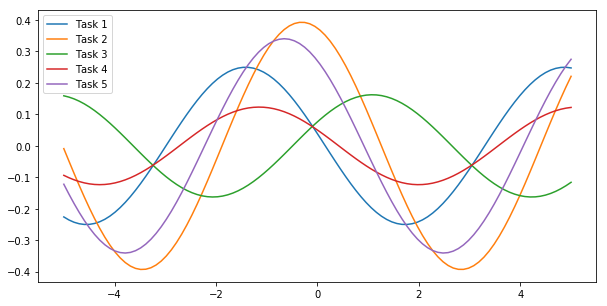

In [16]:
plt.figure(figsize=(10, 5))
x_input_range = np.linspace(-5, 5, 100, dtype=np.float32).reshape((100, 1))

for i in range(5):
    amplitude = np.random.uniform(low=0.1, high=.5)
    phase = np.random.uniform(low=0., high=np.pi)
    y_task = amplitude * np.sin(x_input_range + phase)

    plt.plot(x_input_range, y_task, label="Task {}".format(i + 1))

plt.legend()

In [0]:
def sinusoid_episode(K_shot, amplitude=None, phase=None, N_eval=None):
    if N_eval is None:
        N_eval = K_shot
    
    # sample episode learning task (defined by sin phase and amplitude)
    if amplitude is None or phase is None:
        amplitude = np.random.uniform(low=0.1, high=.5)
        phase = np.random.uniform(low=0., high=np.pi)

    # sample learning examples from episode task
    x_train = np.random.uniform(low=-5., high=5., size=(K_shot, 1))
    x_train = x_train.astype(np.float32)
    y_train = amplitude * np.sin(x_train + phase)

    # sample evaluation examples from episode task
    x_test = np.random.uniform(low=-5., high=5., size=(N_eval, 1))
    x_test = x_test.astype(np.float32)
    y_test = amplitude * np.sin(x_test + phase)

    return x_train, y_train, x_test, y_test

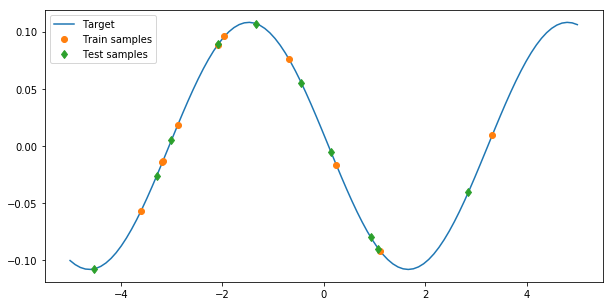

In [18]:
plt.figure(figsize=(10, 5))

amplitude = np.random.uniform(low=0.1, high=.5)
phase = np.random.uniform(low=0., high=np.pi)

x_train, y_train, x_test, y_test = sinusoid_episode(
    10, amplitude=amplitude, phase=phase)

y_task = amplitude * np.sin(x_input_range + phase)

plt.plot(x_input_range, y_task, label="Target".format(i + 1))
plt.plot(x_train, y_train, "o", label="Train samples".format(i + 1))
plt.plot(x_test, y_test, "d", label="Test samples".format(i + 1))

plt.legend()

## Simple Multi-Layer Perception (MLP) trained on a single sine wave task

In [0]:
def create_regression_mlp():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation=tf.nn.relu, input_shape=(1, )),
        tf.keras.layers.Dense(40, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)])

In [0]:
def mse_loss(model, inputs, targets):
    """Compute average mean squared error loss for the inputs batch."""
    predictions = model(inputs)
    return tf.reduce_mean((targets - predictions)**2)

In [0]:
x_input_range = np.linspace(-5, 5, 100, dtype=np.float32).reshape((100, 1))
y_task = 1. * np.sin(x_input_range + 0.)

In [0]:
model = create_regression_mlp()

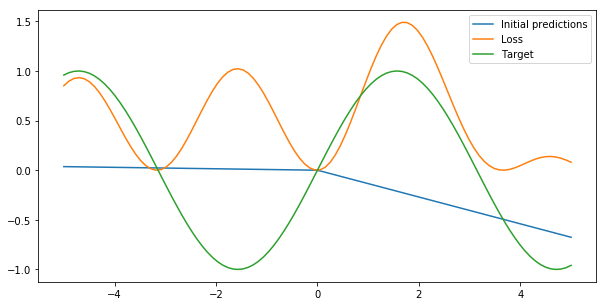

In [23]:
plt.figure(figsize=(10, 5))

initial_predictions = model(x_input_range)

losses = []  # apply loss per-input (no averaging)
for x, y in zip(x_input_range, y_task):
    losses.append(mse_loss(model, np.asarray([x]), np.asarray([y])))

plt.plot(x_input_range, initial_predictions, label="Initial predictions")
plt.plot(x_input_range, losses, label="Loss")
plt.plot(x_input_range, y_task, label="Target")

plt.legend()

In [0]:
def train_step(model, loss, optimizer, x_inputs, y_targets):
    """Train model on (x, y) batch for one gradient update."""
    loss_value = loss(model, x_inputs, y_targets)
    loss_grads = gradient(loss)(
        model, x_inputs, y_targets, targets=model.trainable_variables)

    optimizer.apply_gradients(zip(loss_grads, model.trainable_variables))

    return loss_value

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

for step in range(100):
    loss_value = train_step(model, mse_loss, optimizer, x_input_range, y_task)

    if step % 10 == 0: 
        print("Step: {:03d}, Loss: {:.3f}".format(step, loss_value.numpy()))

Step: 000, Loss: 0.535
Step: 010, Loss: 0.363
Step: 020, Loss: 0.127
Step: 030, Loss: 0.015
Step: 040, Loss: 0.017
Step: 050, Loss: 0.011
Step: 060, Loss: 0.010
Step: 070, Loss: 0.009
Step: 080, Loss: 0.008
Step: 090, Loss: 0.008


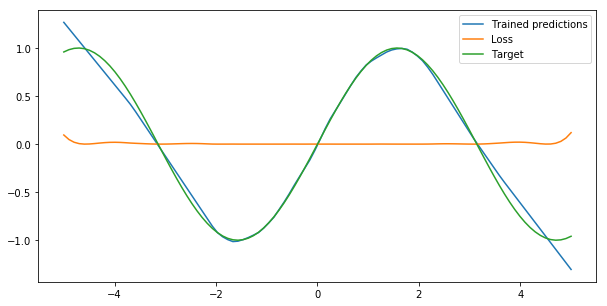

In [26]:
plt.figure(figsize=(10, 5))

trained_predictions = model(x_input_range)

losses = []  # apply loss per-input (no averaging)
for x, y in zip(x_input_range, y_task):
    losses.append(mse_loss(model, np.asarray([x]), np.asarray([y])))

plt.plot(x_input_range, trained_predictions, label="Trained predictions")
plt.plot(x_input_range, losses, label="Loss")
plt.plot(x_input_range, y_task, label="Target")

plt.legend()

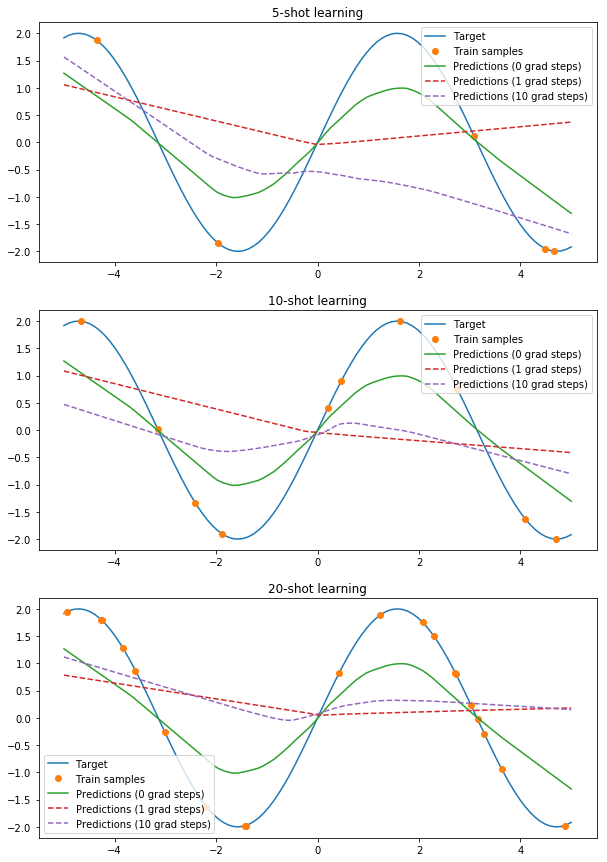

In [27]:
plt.figure(figsize=(10, 5*3))

# define an unseen task with twice the previously seen amplitude
amplitude = 2.
phase = 0.
y_task = amplitude * np.sin(x_input_range + phase)

subplot = 1
for k in [5, 10, 20]:
    plt.subplot(3, 1, subplot)
    subplot += 1

    plt.plot(x_input_range, y_task, label="Target")

    x_train, y_train, _, _ = sinusoid_episode(
        k, amplitude=amplitude, phase=phase)

    plt.plot(x_train, y_train, "o", label="Train samples")

    adapt_model = tf.keras.models.clone_model(model)
    adapt_optimizer = copy.deepcopy(optimizer)

    loss_value = train_step(
            adapt_model, mse_loss, adapt_optimizer, x_train, y_train)
    predictions_1_step = adapt_model(x_input_range)

    for step in range(1, 10):
        loss_value = train_step(
            adapt_model, mse_loss, adapt_optimizer, x_train, y_train)

    predictions_10_step = adapt_model(x_input_range)

    plt.plot(x_input_range, trained_predictions,
             label="Predictions (0 grad steps)")
    plt.plot(x_input_range, predictions_1_step, "--", 
             label="Predictions (1 grad steps)")
    plt.plot(x_input_range, predictions_10_step, "--", 
             label="Predictions (10 grad steps)")
        
    plt.title("{}-shot learning".format(k))
    plt.legend()

## Multi-Layer Perception (MLP) trained on many sine wave tasks

In [0]:
# TODO